In [1]:
# Import required modules
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Load generated data
df = pd.read_csv("./Example Data.csv")
df.head()

,id,Name,Age,Height,Weight,Crime,Banana consumption
0,1,Glyn Vizor,13,164.0,46.4,1016,77.70
1,2,Kynthia Cockney,32,169.7,38.1,922,78.79
2,3,Monro Cristobal,24,156.5,36.6,863,81.80
3,4,Betti Gridley,26,159.5,40.8,742,71.30
4,5,Nollie Jouannin,26,160.6,45.0,666,82.42


In [3]:
# Basic regression
X = df[['Age', 'Height', 'Weight', 'Crime']]
y = df[['Banana consumption']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
regresso = linear_model.LinearRegression()
regresso.fit(X_train, y_train)
print('Model R^2 on train: {:0.2f}'.format(regresso.score(X_train,y_train)))
print('Model R^2 on test: {:0.2f}'.format(regresso.score(X_test,y_test)))
print('Model parameters: {}'.format(regresso.coef_))

Model R^2 on train: 0.73
Model R^2 on test: 0.68
Model parameters: [[9.55720408e-01 2.08013178e-01 3.78988352e-01 3.53248019e-04]]


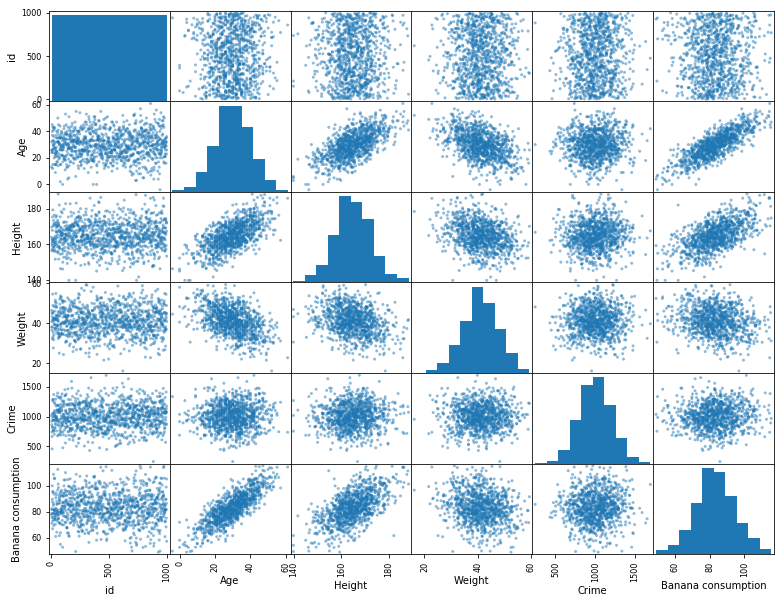

In [4]:
pd.plotting.scatter_matrix(df,figsize=(13,10))
plt.show()

In [5]:
# Some of the variables appear to be related. Can we reduce the dimensionality using principal component analysis?
pca = decomposition.PCA(n_components=2)
pca.fit(X_train)
print('Explained variance ratios: {}'.format(pca.explained_variance_ratio_))
print('The principal components: {}'.format(pca.components_))

Explained variance ratios: [0.99499164 0.00356393]
The principal components: [[ 0.00178868  0.00103801  0.00140897  0.99999687]
 [ 0.81153116  0.49592364 -0.3089896  -0.00153098]]


In [6]:
# Woops! It appears that we should be scaling the data if we don't want features with large numbers to dominate.
ss = StandardScaler()
ss.fit(X_train)
X_train_std = ss.transform(X_train)
X_test_std = ss.transform(X_test)
pca.fit(X_train_std)
print('Explained variance ratios: {}'.format(pca.explained_variance_ratio_))
print('The principal components: {}'.format(pca.components_))

Explained variance ratios: [0.48079653 0.25301162]
The principal components: [[ 0.64501987  0.58937071 -0.48600768  0.01969941]
 [ 0.03974174  0.08047616  0.18996453  0.97767973]]


In [7]:
# Trying regression again with the principal components
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
regresso.fit(X_train_pca, y_train)
print('Model R^2 on train: {:0.2f}'.format(regresso.score(X_train_pca,y_train)))
print('Model R^2 on test: {:0.2f}'.format(regresso.score(X_test_pca,y_test)))
print('Model parameters: {}'.format(regresso.coef_))

Model R^2 on train: 0.51
Model R^2 on test: 0.41
Model parameters: [[6.04093945 1.06793218]]


In [8]:
# What if we had kept 3 principal components?
pca = decomposition.PCA(n_components=3)
pca.fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
regresso.fit(X_train_pca, y_train)
print('Explained variance ratios: {}'.format(pca.explained_variance_ratio_))
print('The principal components: {}'.format(pca.components_))
print('Model R^2 on train: {:0.2f}'.format(regresso.score(X_train_pca,y_train)))
print('Model R^2 on test: {:0.2f}'.format(regresso.score(X_test_pca,y_test)))
print('Model parameters: {}'.format(regresso.coef_))

Explained variance ratios: [0.48079653 0.25301162 0.1843978 ]
The principal components: [[ 0.64501987  0.58937071 -0.48600768  0.01969941]
 [ 0.03974174  0.08047616  0.18996453  0.97767973]
 [-0.13716076 -0.5270407  -0.81278201  0.20688264]]
Model R^2 on train: 0.61
Model R^2 on test: 0.52
Model parameters: [[ 6.04093945  1.06793218 -4.22004629]]


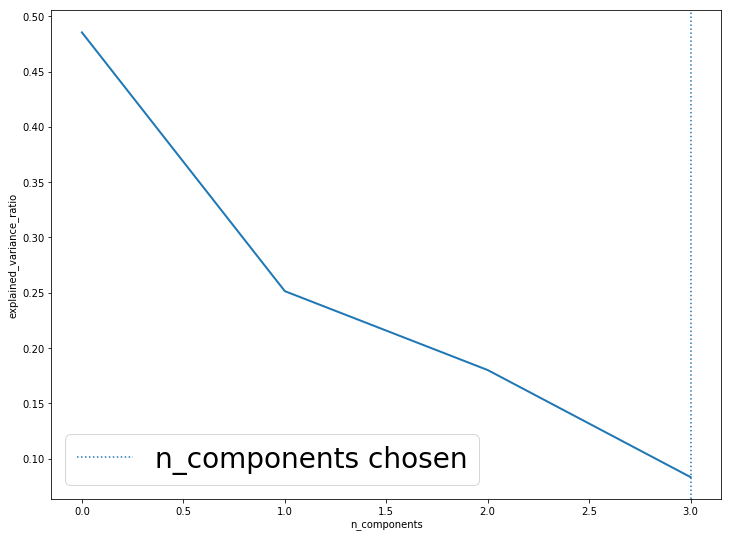

In [9]:
# But how do we select hyperparameters?
X = df[['Age', 'Height', 'Weight', 'Crime']]
y = df[['Banana consumption']]

ss = StandardScaler()
pca = decomposition.PCA()
regresso = linear_model.LinearRegression()

pipe = Pipeline(steps=[('scale', ss), ('pca', pca), ('regress', regresso)])

# Plot the PCA spectrum
pca.fit(ss.fit_transform(X))

plt.figure(1, figsize=(12, 9))
plt.clf()
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio')

n_components = [1, 2, 3, 4]

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components))
estimator.fit(X, y)
plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components-1,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=28))
plt.show()

In [10]:
# Looks like PCA is not that helpful here, but at least we know!
print('Highest R^2 obtained: {:0.2f}'.format(estimator.best_score_))

Highest R^2 obtained: 0.71


In [11]:
# How did the other options fare?
estimator.cv_results_

{'mean_fit_time': array([0.00433326, 0.00533406, 0.00566753, 0.00366656]),
 'mean_score_time': array([0.00100032, 0.00133371, 0.00099929, 0.00033307]),
 'mean_test_score': array([0.46603979, 0.46952021, 0.5804338 , 0.70631991]),
 'mean_train_score': array([0.48259913, 0.48728152, 0.59435478, 0.71559417]),
 'param_pca__n_components': masked_array(data=[1, 2, 3, 4],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': ({'pca__n_components': 1},
  {'pca__n_components': 2},
  {'pca__n_components': 3},
  {'pca__n_components': 4}),
 'rank_test_score': array([4, 3, 2, 1]),
 'split0_test_score': array([0.41546125, 0.42681158, 0.54286635, 0.6695938 ]),
 'split0_train_score': array([0.50566793, 0.51730615, 0.61912282, 0.73569664]),
 'split1_test_score': array([0.43406299, 0.43490031, 0.54352196, 0.69689894]),
 'split1_train_score': array([0.49876354, 0.49888377, 0.60462151, 0.72338405]),
 'split2_test_score': array([0.54874701, 0.5469770